<font size="8"> **Calculating distance to nearest sea ice edge grid cell from all grid cells** </font>  
The sea ice edge was defined as the northernmost grid cells with a sea ice concentration of 10\% or more. The distance from each grid cell in the original data to the closest sea ice edge grid cell was calculated.

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading modules

In [22]:
#Accessing model data
import cosima_cookbook as cc
#Dealing with data
import xarray as xr
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
#Useful packages to deal with file paths
from glob import glob
import os
#Parallelising work
from dask.distributed import Client
#Calculating nearest neighbours
from sklearn.neighbors import BallTree

# Defining dictionary of useful variables
In this dictionary we will define a variables that will be used multiple times throughout this notebook to avoid repetition. It will mostly contain paths to folders where intermediate or final outputs will be stored.

In [4]:
varDict = {'base_folder': '/g/data/v45/la6889/Chapter2_Crabeaters/SeaIceObs/regridded_monthly/*.nc',
           'out_folder': '/g/data/v45/la6889/Chapter2_Crabeaters/SeaIceObs/Distance_Edge/'}

# Loading sea ice concentration (SIC) observational dataset
SIC data comes from [NASA Goddard-merged Near Real Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration](https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-data-nasa-goddard-and-nsidc-based-nasa-team-algorithm) (version 3) dataset and it is available in Gadi.  

The data used here has been regridded to match the ACCESS-OM2-01 model outputs. See the `Obs_SIC-NASA.ipynb` for instructions on how to access and regrid the SIC observations.

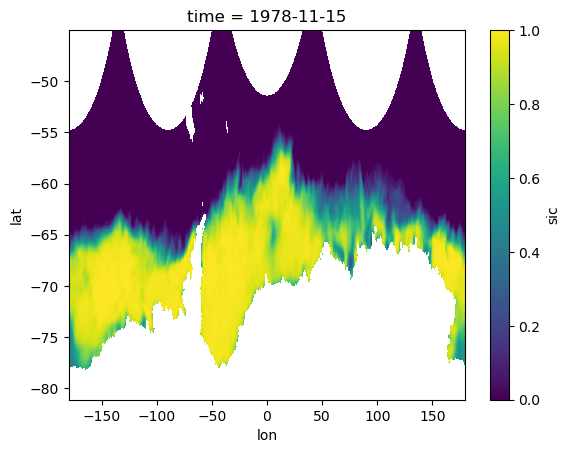

In [14]:
#Loading data
var_ice = xr.open_mfdataset(glob(varDict['base_folder']))
#Renaming variable
var_ice = var_ice.rename_vars({'__xarray_dataarray_variable__': 'sic'})
#Loading as data array
var_ice = var_ice.sic
#Checking result
var_ice

# Finding sea ice edge
The sea ice edge is the defined as the northernmost areas where sea ice concentration (SIC) is under $10\%$. This is a multistep process:
1. Identify pixels where SIC is greater or equal to 0.1, and change value to 1,
2. Calculate cumulate sum along y axis,
3. Apply mask to remove original `NaN` values from cumulative sums.

This will result in pixels with the highest value along the y axis to be identified as the sea ice edge. 

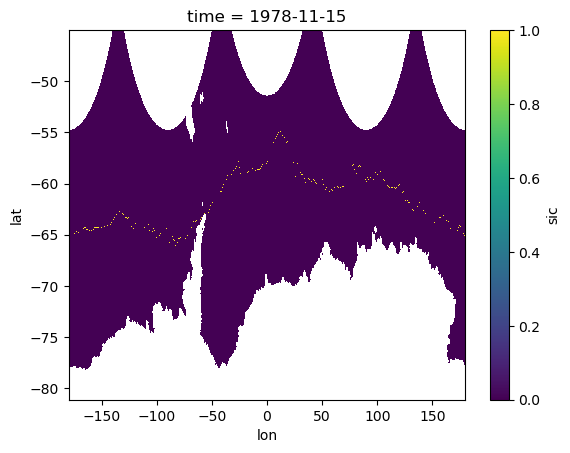

In [15]:
#Assign a value of 1 to any areas where SIC is at least 0.1
ice_10 = xr.where(var_ice >= 0.1, 1, np.nan)

#Adding all cells along y axis. Masking out NA values
ice_10 = ice_10.cumsum(dim = 'lat', skipna = True).where(~np.isnan(ice_10))

#Finding cells with highest value along y axis. This identifies the ice edge at each longitude.
ice_10 = xr.where(ice_10 == ice_10.max('lat'), 1, 0).where(~np.isnan(var_ice))

#Checking result for first time step
ice_10.isel(time = 0).plot()

## Checking results in relation to SIC data

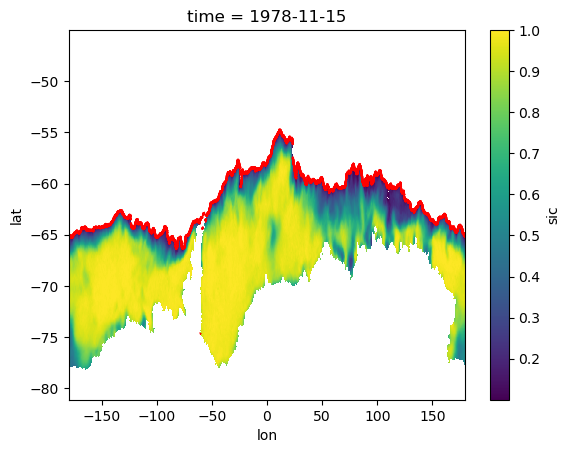

In [16]:
#Checking results for first time step
fig = plt.figure()
ax = fig.add_subplot(111)
var_ice.where(var_ice >= 0.1)[0].plot(ax = ax)
ice_10[0].plot.contour(ax = ax, colors = ['red'])

Above we plotted only pixels with SIC greater or equal to 0.1. The red line represents the sea ice edge we identified in the previous step. We can be satisfied that we identified the sea ice edge correctly.

# Getting coordinate pairs for each cell in the original grid
We will use the latitude and longitude values in our data to create coordinate pairs. We only need to get this information once if we are calculating distances from the same grid.  
  
We also need to transform coordinate pairs to radians as this is needed in the calculation of distances.

In [17]:
#Storing longitude and latitude values
x, y = np.meshgrid(np.deg2rad(var_ice.lon.values),
                   np.deg2rad(var_ice.lat.values))

#Changing shape so there are two values per row
grid_coords = np.vstack([y.flat, x.flat]).T

#Removing variables not needed
del x, y

# Calculating distance to closest sea ice edge cell
We will define a function called `nn_dist` that will apply the following steps to get the distance from each grid cell to the sea ice edge:
1. Get coordinate pairs of sea ice edge,
2. Use Nearest Neighbour algorithm to calculate distance to closest ice edge cell,
3. Transform distance from radians to kilometers,
4. Store result in a data array,
5. Save output to disk (optional).
  
We will apply this function to each time step in the data frame that contains our sea ice edge.

In [19]:
def nn_dist(target_da, grid_coords_numpy, folder_out, file_base):
    #Getting coordinate pairs for sea ice edge
    ice_coords = np.vstack([target_da.lat[target_da.argmax(dim = 'lat')],
                            target_da.lon]).T
    
    #Set up Ball Tree (nearest neighbour algorithm).
    ball_tree = BallTree(np.deg2rad(ice_coords), metric = 'haversine')
    #The nearest neighbour calculation will give two outputs: distances in radians and indices
    dist_rad, ind = ball_tree.query(grid_coords_numpy, return_distance = True)
    #Transform distances from radians to km and changing data to data array
    earth_radius_km = 6371
    dist_km = xr.DataArray(data = [(dist_rad*earth_radius_km).reshape(target_da.shape)],
                           dims = ['time', 'lat', 'lon'],
                           coords = {'time': [target_da.time.values],
                                     'lat': target_da.lat.values,
                                     'lon': target_da.lon.values},
                           name = 'dist_km')
    dist_km = dist_km.assign_attrs({'units': 'km',
                          'long_name': 'distance to nearest neighbour'})
    
    #Make sure output folder exists
    os.makedirs(folder_out, exist_ok = True)
    #Extract year and month to use in filename
    month = str(dist_km.time.dt.month.values[0]).zfill(2)
    year = dist_km.time.dt.year.values[0]
    file_out = os.path.join(folder_out, f'{file_base}_{year}-{month}.nc')
    dist_km.to_netcdf(file_out)
    
    return dist_km

In [ ]:
#Applying function for each time step in the sea ice edge data array
for t in ice_10:
    da = nn_dist(t, grid_coords,
                    folder_out = varDict['out_folder'],
                    file_base = 'Distance_Sea_Ice_Edge_Obs_')

## Loading all outputs saved to disk
We can load all results in a single dataset to check our results.

In [19]:
dist_ice_edge = xr.open_mfdataset(os.path.join(varDict['base_folder'], '*.nc')).dist_km
dist_ice_edge

<xarray.DataArray 'dist_km' (time: 493, yt_ocean: 740, xt_ocean: 3600)>
dask.array<concatenate, shape=(493, 740, 3600), dtype=float64, chunksize=(1, 740, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1977-12-31T12:00:00 ... 2018-12-31T12:00:00
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95

## Plotting results
We will check the first three time steps in our data array.

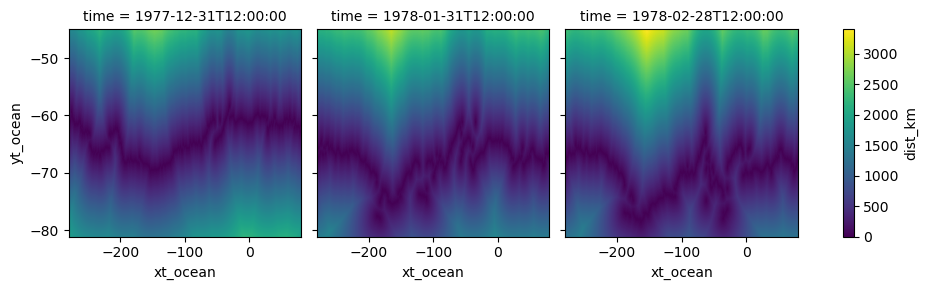

In [18]:
dist_ice_edge.isel(time = slice(0, 3)).plot(col = 'time')

These results make sense as we expect the sea ice to retreat during summer months (December to February). We can overlay the sea ice edge on the distance calculations to visually inspect the accuracy of our calculations.

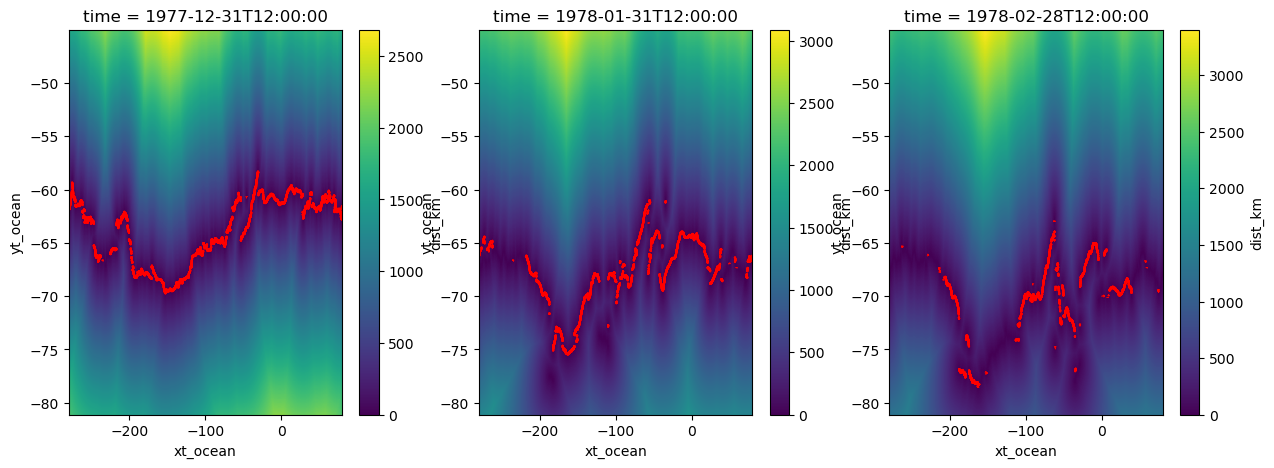

In [30]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

for i in range(0, 3):
    dist_ice_edge.isel(time = i).plot(ax = axs[i])
    ice_10.isel(time = i).plot.contour(ax = axs[i], colors = ['red'])